<a href="https://colab.research.google.com/github/vikxoxo/Computer-Vision/blob/master/CV5_SVHN_CNN_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>SVHN Classification using CNNs</h1>

---



# Importing Keras Modules


In [10]:
#Importing important modules
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
#Installing Tensorboard for Colab
!pip install tensorboardcolab

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
root_path = '/content/drive/My Drive/DataSets'  #change dir to your project folder

In [13]:
import os
from os import path
import shutil

In [17]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{u'kaggle.json': '{"username":"vikanksh","key":"dda4ebcc1e5882aacdabc8eb6906d257"}'}

In [18]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [19]:
file_path = os.path.join(root_path, "street-view-house-nos-h5-file.zip")
print(file_path)

/SVHN_single_grey1.h5


In [22]:
if(path.isfile(file_path)==False):
  os.chdir(root_path)  #change dir
  # !wget 'https://www.kaggle.com/sasha18/street-view-house-nos-h5-file/download'
  !kaggle datasets download -d sasha18/street-view-house-nos-h5-file

100% 385M/387M [00:16<00:00, 17.3MB/s]
100% 387M/387M [00:17<00:00, 23.8MB/s]


In [23]:
os.chdir(root_path)  #change dir
# !mkdir svhnH5  #create a directory named unzip/
!unzip -q street-view-house-nos-h5-file.zip   #unzip data in train/

# Loading the Dataset

<h3>Import train and test sets of  SVHN dataset</h3>

In [26]:
import h5py
import numpy as np

# Open the file as readonly
h5f = h5py.File('/content/drive/My Drive/DataSets/SVHN_single_grey1.h5', 'r')

# see what is inside that h5 file
print(h5f.keys())

# Load the training, test and validation set
x_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
x_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()


[u'X_test', u'X_train', u'X_val', u'y_test', u'y_train', u'y_val']


<h4>Visualizing the dataset</h4>
(Visualize first 25 test images from the dataset using matplotlib)  **2.5 Points**

In [29]:
x_test.shape

(18000, 32, 32)

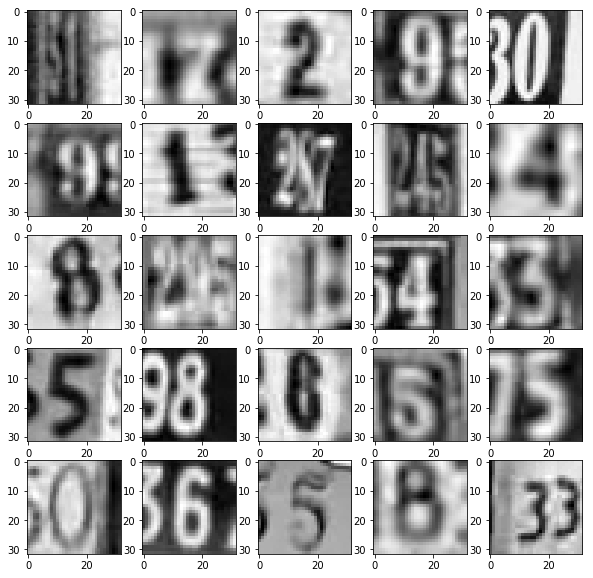

In [32]:
# modules we need

import numpy as np  
import matplotlib.pyplot as plt  
import h5py

plt.subplots(5,5,figsize = (10,10))

for i in range(25):
    img_np = x_test[i]
    plt.subplot(5,5,1+i)
    plt.imshow(img_np, cmap = 'gray')
plt.show()

<h3>Reshape train and test sets into shapes compatible with keras models</h3>

<h4>Keras expects data to be in the format (N_E.N_H,N_W,N_C)  N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.</h4>


In [33]:
# input image dimensions
img_rows, img_cols = 32, 32

#Keras expects data to be in the format (N_E.N_H,N_W,N_C)
#N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

<h3>Pre-processing the dataset</h3>
<h4>Normalizing the input</h4>

In [34]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Normalizing the input
x_train /= 255.0
x_test /= 255.0
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

('x_train shape:', (42000, 32, 32, 1))
(42000, 'train samples')
(18000, 'test samples')


In [36]:
batch_size = 128
num_classes = 10
epochs = 12

<h4>Convert Labels from digits to one hot vectors</h4>  **2.5 Points**

In [37]:
# convert class vectors to binary class matrices
y_train1 = keras.utils.to_categorical(y_train, num_classes)
y_test1 = keras.utils.to_categorical(y_test, num_classes)

In [38]:
print(y_train[0])

2


In [39]:
print(y_train1[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


# Building the CNN 

<h4>Define the layers of model</h4>  **5 Points**

In [48]:
#Initialize the model
model = Sequential()

#Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
model.add(Conv2D(64, (3, 3), activation='relu'))

#Add a MaxPooling Layer of size 2X2 
model.add(MaxPooling2D(pool_size=(2, 2)))

#Apply Dropout with 0.25 probability 
model.add(Dropout(0.25))

#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
model.add(Conv2D(128, (3, 3), activation='relu'))

#Add a MaxPooling Layer of size 2X2 
model.add(MaxPooling2D(pool_size=(2, 2)))

#Apply Dropout with 0.25 probability 
model.add(Dropout(0.5))

#Flatten the layer
model.add(Flatten())

#Add Fully Connected Layer with 128 units and activation function as 'ReLU'
model.add(Dense(128, activation='relu'))

#Apply Dropout with 0.5 probability 
model.add(Dropout(0.5))

#Add Fully Connected Layer with 10 units and activation function as 'softmax'
model.add(Dense(num_classes, activation='softmax'))

<h4>Set Adam Optimizer and Loss function for training</h4>  **2.5 Points**

In [49]:
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

#To use adam optimizer for learning weights with learning rate = 0.001
optimizer = Adam(lr=0.001)
#Set the loss function and optimizer for the model training
model.compile(loss=categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

# Training the CNN - 10 Points

<h4>Initializing the Tensorboard callback for visualization of training</h4>

In [50]:
#Import tensorboard callback which will passed in model.fit function.
from keras.callbacks import TensorBoard
from time import time


#Setting the directory to store the logs.
tensorboard = TensorBoard(log_dir=".logs/{}".format(time()))

<h4>Initializing Early stopping and Model chekpoint callbacks </h4>

In [51]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('svhn_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

<h4>Fit the model to the dataset</h4>

In [52]:

#Training on the dataset and adding the all the callbacks to the fit function.
#Once the training starts, results start appearing on Tensorboard after 1 epoch
#important to note, use one hot encoded labels y_train1 , y_test1
model.fit(x_train, y_train1,  
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test1),
          callbacks=[early_stopping,model_checkpoint])

Train on 42000 samples, validate on 18000 samples
Epoch 1/12
42000/42000 [==============================] - 10s 239us/step - loss: 1.4905 - accuracy: 0.4822 - val_loss: 0.6115 - val_accuracy: 0.8209

Epoch 00001: val_loss improved from inf to 0.61152, saving model to svhn_cnn_checkpoint_01_loss0.6115.h5
Epoch 2/12
42000/42000 [==============================] - 9s 222us/step - loss: 0.7381 - accuracy: 0.7757 - val_loss: 0.4973 - val_accuracy: 0.8596

Epoch 00002: val_loss improved from 0.61152 to 0.49726, saving model to svhn_cnn_checkpoint_02_loss0.4973.h5
Epoch 3/12
42000/42000 [==============================] - 9s 223us/step - loss: 0.6390 - accuracy: 0.8037 - val_loss: 0.4258 - val_accuracy: 0.8742

Epoch 00003: val_loss improved from 0.49726 to 0.42579, saving model to svhn_cnn_checkpoint_03_loss0.4258.h5
Epoch 4/12
42000/42000 [==============================] - 10s 233us/step - loss: 0.5841 - accuracy: 0.8219 - val_loss: 0.4011 - val_accuracy: 0.8820

Epoch 00004: val_loss improve

# Evaluating the CNN

<h4>Evaluate trained model on the test set</h4>  ** 2.5 Points**

In [54]:
#Testing the model on test set
score = model.evaluate(x_test, y_test1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

18000/18000 [==============================] - 3s 167us/step
('Test loss:', 0.3137002735204167)
('Test accuracy:', 0.9095555543899536)


<h4>Visualize 5 test set image predictions</h4>  **2.5 Points**

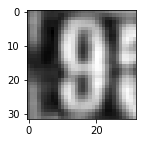

9


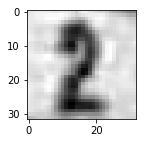

2


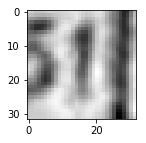

1


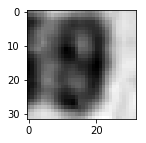

9


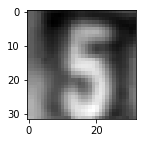

5


In [56]:
import numpy as np

plt.figure(figsize=(2,2))
plt.imshow(x_test[3].reshape(32,32),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[3].reshape(1,32,32,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[2].reshape(32,32),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[2].reshape(1,32,32,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[33].reshape(32,32),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[33].reshape(1,32,32,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[59].reshape(32,32),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[59].reshape(1,32,32,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[36].reshape(32,32),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[36].reshape(1,32,32,1))))

# Saving the CNN

<h4>Save the trained weights and model in h5 files</h4>  **2.5 Points**

In [57]:
#Set the path where you want to store the model and weights. 
#/content/mnist_cnn_checkpoint_03_loss0.0344.h5
model.save('/content/cnn_svhn.h5')
model.save_weights('/content/cnn_svhn_weights.h5')